In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import pandas as pd
full_merged = pd.read_csv('../merged_data/full_info_dataframe.csv')
full_merged.head()

/var/folders/yr/gmmc3xcx5xg406qfnj2bnx340000gn/T/ipykernel_89628/695658290.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  full_merged= pd.read_csv('../merged_data/full_info_dataframe.csv')


,client_id,visitor_id,visit_id,process_step,date_time,is_client,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,True,5.0,64.0,79.0,NaN,2.0,189023.86,1.0,4.0,Test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,True,5.0,64.0,79.0,NaN,2.0,189023.86,1.0,4.0,Test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,True,5.0,64.0,79.0,NaN,2.0,189023.86,1.0,4.0,Test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,True,5.0,64.0,79.0,NaN,2.0,189023.86,1.0,4.0,Test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:17:15,True,5.0,64.0,79.0,NaN,2.0,189023.86,1.0,4.0,Test


/var/folders/yr/gmmc3xcx5xg406qfnj2bnx340000gn/T/ipykernel_89628/1877821770.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backward_df['is_repeated'] = backward_df.duplicated(['visitor_id', 'process_step'], keep=False)


  variation  total_attempts  error_attempts  error_rate
0   Control           67837           53265   78.519097
1      Test           90953           73987   81.346410


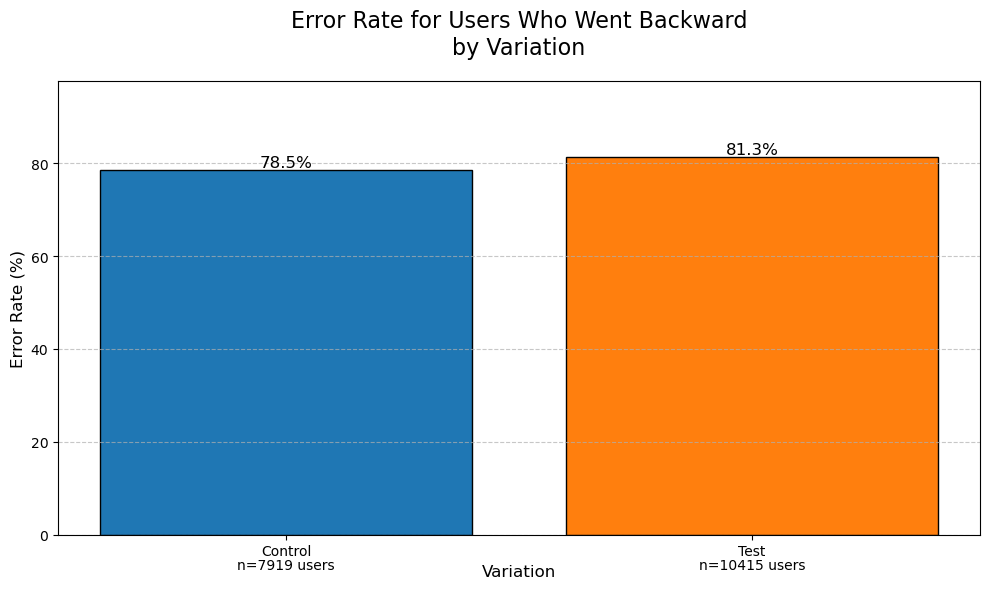

In [6]:
# Convert date_time to datetime and sort
full_merged['date_time'] = pd.to_datetime(full_merged['date_time'])
full_merged =full_merged.sort_values(['visitor_id', 'date_time'])

# Create mapping of step order
step_order = {'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4}
full_merged['step_num'] = full_merged['process_step'].map(step_order)

# Identify backward movements
full_merged['next_step'] = full_merged.groupby('visitor_id')['step_num'].shift(-1)
full_merged['step_diff'] = full_merged['next_step'] - full_merged['step_num']
full_merged['went_backward'] = full_merged['step_diff'] < 0

# Calculate error rates by variation
def calculate_backward_error_rates(df):
    # Filter to only users who went backward at least once
    backward_users = full_merged[full_merged['went_backward']]['visitor_id'].unique()
    backward_df = full_merged[full_merged['visitor_id'].isin(backward_users)]
    
    # Calculate error rates (repeated steps) for these users
    backward_df['is_repeated'] = backward_df.duplicated(['visitor_id', 'process_step'], keep=False)
    
    # Group by variation
    total_attempts = backward_df.groupby('variation').size().reset_index(name='total_attempts')
    error_attempts = backward_df[backward_df['is_repeated']].groupby('variation').size().reset_index(name='error_attempts')
    
    # Merge and calculate error rate
    error_rates = pd.merge(total_attempts, error_attempts, on='variation', how='left')
    error_rates['error_attempts'] = error_rates['error_attempts'].fillna(0)
    error_rates['error_rate'] = (error_rates['error_attempts'] / error_rates['total_attempts']) * 100
    print(error_rates)
    return error_rates

backward_error_rates = calculate_backward_error_rates(full_merged)

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(backward_error_rates['variation'], backward_error_rates['error_rate'],
               color=['#1f77b4', '#ff7f0e'], edgecolor='black')

plt.title('Error Rate for Users Who Went Backward\nby Variation', fontsize=16, pad=20)
plt.xlabel('Variation', fontsize=12)
plt.ylabel('Error Rate (%)', fontsize=12)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=12)

# Add sample size annotations
sample_sizes =   full_merged[  full_merged['visitor_id'].isin(  full_merged[  full_merged['went_backward']]['visitor_id'].unique())]\
                .groupby('variation')['visitor_id'].nunique()
for i, var in enumerate(backward_error_rates['variation']):
    plt.text(i, -5, f'n={sample_sizes[var]} users',
             ha='center', va='top', fontsize=10)

plt.ylim(0, max(backward_error_rates['error_rate']) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [4]:
# Percentage of users who went backward by variation
backward_users = full_merged[full_merged['went_backward']].groupby('variation')['visitor_id'].nunique()
total_users = full_merged.groupby('variation')['visitor_id'].nunique()
backward_pct = (backward_users / total_users * 100).reset_index(name='pct_backward')

print("\nPercentage of users who went backward:")
print(backward_pct)

# Average number of backward movements per user
backward_counts = full_merged[full_merged['went_backward']].groupby(['variation', 'visitor_id']).size()\
                    .groupby('variation').mean().reset_index(name='avg_backward_moves')
print("\nAverage backward movements per user:")
print(backward_counts)


Percentage of users who went backward:
  variation  pct_backward
0   Control     29.638087
1      Test     34.473077

Average backward movements per user:
  variation  avg_backward_moves
0   Control            1.580894
1      Test            1.783595


In [7]:
full_merged.to_csv('../merged_data/full_merged.csv', index=False)
print("Data exported successfully!")

Data exported successfully!
